# 1. Setup

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# load datasets
weather = pd.read_csv("boston-weather-data(open_meteo) (1).csv", skiprows=3)
print(weather.columns.tolist())
pollution = pd.read_csv("boston_pollutants_with_aqi.csv")
pollen = pd.read_csv("EPHT_Pollen_Data.csv")

# parse date columns
weather['time'] = pd.to_datetime(weather['time'])
pollution['date'] = pd.to_datetime(pollution['date'])
pollen['Date'] = pd.to_datetime(pollen['Date'])

# rename and merge
weather.rename(columns={'time': 'Date'}, inplace=True)
pollution.rename(columns={'date': 'Date'}, inplace=True)

merged = (
    weather
    .merge(pollution, on='Date', how='inner')
    .merge(pollen, on='Date', how='inner')
)

merged.info()

# filter for pollen season (March through October)
merged = merged[merged['Date'].dt.month.isin(range(3, 11))]


# select relevant numeric columns
cols = [
    # Weather (all numeric)
    'weather_code (wmo code)',
    'temperature_2m_mean (°C)',
    'apparent_temperature_mean (°C)',
    'precipitation_sum (mm)',
    'wind_gusts_10m_max (km/h)',
    'wind_speed_10m_max (km/h)',
    'wind_direction_10m_dominant (°)',

    # Pollution
    'PM2.5', 'O3', 'CO', 'NO2', 'SO2',
    'AQI_PM2.5', 'AQI_O3', 'AQI_CO', 'AQI_NO2', 'AQI_SO2',
    'AQI', 'num_pollutants_available',

    # Pollen
    'Tree', 'Grass', 'Weed', 'Ragweed', 'Total_Pollen'
]

numeric = merged[[c for c in cols if c in merged.columns]]
corr = numeric.corr()



['time', 'temperature_2m_mean (°C)', 'precipitation_sum (mm)', 'apparent_temperature_mean (°C)', 'wind_gusts_10m_max (km/h)', 'wind_speed_10m_max (km/h)', 'wind_direction_10m_dominant (°)']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2066 entries, 0 to 2065
Data columns (total 34 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   Date                             2066 non-null   datetime64[ns]
 1   temperature_2m_mean (°C)         2066 non-null   float64       
 2   precipitation_sum (mm)           2066 non-null   float64       
 3   apparent_temperature_mean (°C)   2066 non-null   float64       
 4   wind_gusts_10m_max (km/h)        2066 non-null   float64       
 5   wind_speed_10m_max (km/h)        2066 non-null   float64       
 6   wind_direction_10m_dominant (°)  2066 non-null   int64         
 7   PM2.5                            2057 non-null   float64       
 8   O3      

# 2. Linear Regression Model - Not Very Good


In [186]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# use the merged dataframe
df = merged.copy()

# drop rows with missing values in predictors or target
df = df.dropna(subset=numeric.columns)

# ------------------------------
# 1. Select target + features
# ------------------------------
target = "Total_Pollen"   
remove_cols = ["Tree", "Grass", "Weed", "Ragweed", "Total_Pollen"] # remove pollen related variables 
features = [c for c in numeric.columns if c not in remove_cols]

X = df[features]
y = df[target]

# ------------------------------
# 2. Split data
# ------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ------------------------------
# 3. Scale features
# ------------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ------------------------------
# 4. Train linear regression
# ------------------------------
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# ------------------------------
# 5. Model evaluation
# ------------------------------
y_pred = model.predict(X_test_scaled)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R²:", r2_score(y_test, y_pred))

# ------------------------------
# 6. Coefficients (feature importance for linear regression)
# ------------------------------
coef_df = pd.DataFrame({
    "feature": features,
    "coefficient": model.coef_
}).sort_values(by="coefficient", key=abs, ascending=False)

print(coef_df)


MAE: 89.0091943339086
RMSE: 176.08537156205279
R²: 0.1230744813575092
                            feature  coefficient
12                           AQI_O3   231.282516
14                          AQI_NO2   205.743983
7                                O3  -178.997588
9                               NO2  -172.943937
1    apparent_temperature_mean (°C)  -171.120067
0          temperature_2m_mean (°C)   141.824499
6                             PM2.5   -47.742608
15                          AQI_SO2   -41.828785
11                        AQI_PM2.5    23.835272
16                              AQI    23.519343
3         wind_gusts_10m_max (km/h)   -18.525209
5   wind_direction_10m_dominant (°)   -15.140248
8                                CO   -10.531590
10                              SO2     8.325233
13                           AQI_CO    -5.494664
4         wind_speed_10m_max (km/h)     5.014623
2            precipitation_sum (mm)    -1.085136
17         num_pollutants_available     0.000000

# 3. Random Forest

In [233]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --- copy dataframe ---
df = merged.copy()

# --- drop rows w/ NA in numeric columns ---
df = df.dropna(subset=numeric.columns)

# ==============================================================
# 1. BASIC ENGINEERED FEATURES (your original)
# ==============================================================

df["day_of_year"] = df["Date"].dt.dayofyear
df["lag1"] = df["Total_Pollen"].shift(1)
df["lag2"] = df["Total_Pollen"].shift(2)
df["lag3"] = df["Total_Pollen"].shift(3)
df["pollen_3day"] = df["Total_Pollen"].rolling(3).mean()
df["pollen_7day"] = df["Total_Pollen"].rolling(7).mean()

# spike indicator: 1 if pollen > mean + 1 std
threshold = df["Total_Pollen"].mean() + df["Total_Pollen"].std()
df["is_spike"] = (df["Total_Pollen"] > threshold).astype(int)

# drop NA from new features
df = df.dropna(subset=["lag1", "lag2", "lag3", "pollen_3day", "pollen_7day"])

# ==============================================================
# 2. ORIGINAL FEATURE LISTS
# ==============================================================

target = "Total_Pollen"
remove_cols = ["Tree", "Grass", "Weed", "Ragweed", "Total_Pollen"]

base_features = [c for c in numeric.columns if c not in remove_cols]
extra_features = ["day_of_year", "lag1", "lag2", "lag3", "pollen_3day", "pollen_7day", "is_spike"]

features = base_features + extra_features

X = df[features]
y = df[target]

# ==============================================================
# 3. ADVANCED FEATURES FROM SUCCESSFUL SCRIPT
# ==============================================================

# --- Seasonal sin/cos ---
X = df[features].copy()

# --- Seasonal sin/cos ---
X["sin_day"] = np.sin(2 * np.pi * X["day_of_year"] / 365)
X["cos_day"] = np.cos(2 * np.pi * X["day_of_year"] / 365)
X = X.drop(columns=["day_of_year"])

# --- Weighted rolling averages (3-day) ---
weights = np.array([0.1, 0.3, 0.6])  # older → newer emphasis

rolling_cols = [
    "temperature_2m_mean (°C)", "apparent_temperature_mean (°C)",
    "PM2.5", "O3", "CO", "NO2", "SO2",
    "AQI_PM2.5", "AQI_O3", "AQI_CO", "AQI_NO2", "AQI_SO2", "AQI"
]

for col in rolling_cols:
    X[f"{col}_weighted3"] = (
        X[col].shift(2).bfill() * weights[0] +
        X[col].shift(1).bfill() * weights[1] +
        X[col] * weights[2]
    )

# --- Lag features (t-1, t-2, t-3) for pollutants/meteo ---
for col in rolling_cols:
    for lag in range(1, 4):
        X[f"{col}_lag{lag}"] = X[col].shift(lag).bfill()

# --- Interaction features ---
interaction_pairs = [
    ("temperature_2m_mean (°C)", "AQI"),
    ("apparent_temperature_mean (°C)", "PM2.5"),
    ("wind_speed_10m_max (km/h)", "O3"),
]

for col1, col2 in interaction_pairs:
    X[f"{col1}_x_{col2}"] = X[col1] * X[col2]

# ==============================================================
# 4. LOG-TRANSFORM TARGET
# ==============================================================

y_log = np.log1p(y)

# ==============================================================
# 5. TRAIN/TEST SPLIT
# ==============================================================

X_train, X_test, y_train, y_test = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)

# ==============================================================
# 6. RANDOM FOREST MODEL
# ==============================================================

rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=4,
    max_features=None,
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

# --- prediction ---
y_pred_log = rf.predict(X_test)
y_pred = np.expm1(y_pred_log)

# ==============================================================
# 7. METRICS
# ==============================================================

# --- Predictions ---
y_train_pred_log = rf.predict(X_train)
y_test_pred_log  = rf.predict(X_test)

# inverse log-transform
y_train_pred = np.expm1(y_train_pred_log)
y_test_pred  = np.expm1(y_test_pred_log)

y_train_real = np.expm1(y_train)
y_test_real  = np.expm1(y_test)

print("Training Metrics:")
print("MAE:", mean_absolute_error(y_train_real, y_train_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_train_real, y_train_pred)))
print("R²:", r2_score(y_train_real, y_train_pred))

print("\nTest Metrics:")
print("MAE:", mean_absolute_error(y_test_real, y_test_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test_real, y_test_pred)))
print("R²:", r2_score(y_test_real, y_test_pred))

# ==============================================================
# 8. FEATURE IMPORTANCE
# ==============================================================

importances = pd.DataFrame({
    "feature": X_train.columns,
    "importance": rf.feature_importances_
}).sort_values(by="importance", ascending=False)

print(importances)


Training Metrics:
MAE: 19.594913547020006
RMSE: 79.09998321061745
R²: 0.9048637896565804

Test Metrics:
MAE: 19.82751368554866
RMSE: 51.99203451441397
R²: 0.8967909754371932
                     feature  importance
21               pollen_3day    0.827944
23                  is_spike    0.073938
19                      lag2    0.018244
18                      lag1    0.014251
2     precipitation_sum (mm)    0.002986
..                       ...         ...
13                    AQI_CO    0.000041
74              AQI_SO2_lag3    0.000038
73              AQI_SO2_lag2    0.000022
72              AQI_SO2_lag1    0.000014
17  num_pollutants_available    0.000000

[81 rows x 2 columns]


# 4. LightGBM


In [189]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import lightgbm as lgb

# --------------------------
# 1. Prepare dataframe
# --------------------------
df = merged.copy()

# Drop rows with missing numeric features
df = df.dropna(subset=numeric.columns)

# Create lag and rolling features
df["day_of_year"] = df["Date"].dt.dayofyear
df["lag1"] = df["Total_Pollen"].shift(1)
df["lag2"] = df["Total_Pollen"].shift(2)
df["lag3"] = df["Total_Pollen"].shift(3)
df["pollen_3day"] = df["Total_Pollen"].rolling(3).mean()
df["pollen_7day"] = df["Total_Pollen"].rolling(7).mean()

# Create spike feature (example: > 75th percentile of recent 3-day mean)
df["is_spike"] = ((df["Total_Pollen"] - df["pollen_3day"]) > df["pollen_3day"].quantile(0.75)).astype(int)

df = df.dropna(subset=["lag1", "lag2", "lag3", "pollen_3day", "pollen_7day"])

# --------------------------
# 2. Define target & features
# --------------------------
target = "Total_Pollen"
remove_cols = ["Tree", "Grass", "Weed", "Ragweed", "Total_Pollen"]

base_features = [c for c in numeric.columns if c not in remove_cols]
extra_features = ["day_of_year", "lag1", "lag2", "lag3", "pollen_3day", "pollen_7day", "is_spike"]
features = base_features + extra_features

X = df[features]
y = df[target]

# --------------------------
# 3. Train/test split
# --------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# --------------------------
# 4. LightGBM model
# --------------------------
lgb_reg = lgb.LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    random_state=42
)

# Fit with early stopping
lgb_reg.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='rmse',
    callbacks=[lgb.early_stopping(50), lgb.log_evaluation(50)]
)

# --------------------------
# 5. Predictions
# --------------------------
y_pred = lgb_reg.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R²:", r2_score(y_test, y_pred))

# --------------------------
# 6. Feature importance
# --------------------------
importances = pd.DataFrame({
    "feature": features,
    "importance": lgb_reg.feature_importances_
}).sort_values(by="importance", ascending=False)

print(importances)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000735 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3572
[LightGBM] [Info] Number of data points in the train set: 1022, number of used features: 24
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 88.673611
Training until validation scores don't improve for 50 rounds
[50]	valid_0's rmse: 56.9294	valid_0's l2: 3240.95
[100]	valid_0's rmse: 54.4161	valid_0's l2: 2961.11
[150]	valid_0's rmse: 50.533	valid_0's l2: 2553.58
[200]	valid_0's rmse: 48.547	valid_0's l2: 2356.81
[250]	valid_0's rmse: 47.6874	valid_0's l2: 2274.08
[300]	valid_0's rmse: 45.9382	valid_0's l2: 2110.32
[350]	valid_0's rmse: 44.6775	valid_0's l2: 1996.08
[400]	valid_0's rmse: 44.2033	valid_0's l2: 1953.93
[450]	valid_0's rmse: 44

# 5. XGBoost


[0]	train-rmse:245.12693	eval-rmse:158.47520
[50]	train-rmse:44.51547	eval-rmse:65.90696
[100]	train-rmse:15.08489	eval-rmse:59.66321
[150]	train-rmse:7.05198	eval-rmse:58.61257
[200]	train-rmse:4.23123	eval-rmse:58.32035
[250]	train-rmse:2.88940	eval-rmse:58.18420
[300]	train-rmse:1.92138	eval-rmse:58.20574
[302]	train-rmse:1.86867	eval-rmse:58.20549
MAE: 21.17713635238353
RMSE: 58.205485301835694
R²: 0.8706483782023682
                      feature    importance
22                   is_spike  3.635062e+06
20                pollen_3day  1.553810e+05
4   wind_speed_10m_max (km/h)  9.129661e+04
29               CO_weighted3  8.558873e+04
72               AQI_SO2_lag3  8.032044e+04
..                        ...           ...
59             AQI_PM2.5_lag1  8.140540e+02
35          AQI_NO2_weighted3  6.951923e+02
24                    cos_day  3.570451e+02
68               AQI_NO2_lag1  2.516768e+02
65                AQI_CO_lag1  1.754701e+01

[79 rows x 2 columns]


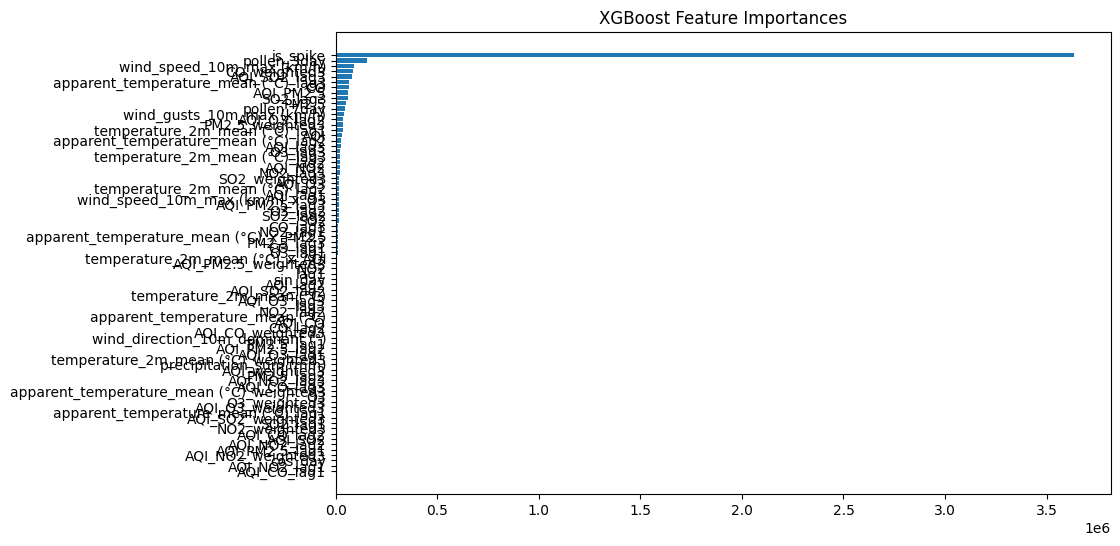

In [235]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# --------------------------
# 1. Prepare dataframe
# --------------------------
df = merged.copy()

# Drop rows with missing numeric features
df = df.dropna(subset=numeric.columns)

# Create base pollen lags + rolling
df["day_of_year"] = df["Date"].dt.dayofyear
df["lag1"] = df["Total_Pollen"].shift(1)
df["lag2"] = df["Total_Pollen"].shift(2)
df["lag3"] = df["Total_Pollen"].shift(3)
df["pollen_3day"] = df["Total_Pollen"].rolling(3).mean()
df["pollen_7day"] = df["Total_Pollen"].rolling(7).mean()

# Spike indicator: pollen surge
threshold = df["Total_Pollen"].mean() + df["Total_Pollen"].std()
df["is_spike"] = (df["Total_Pollen"] > threshold).astype(int)

# Drop NA caused by shifting
df = df.dropna(subset=["lag1", "lag2", "lag3", "pollen_3day", "pollen_7day"])

# --------------------------
# 2. Seasonal sin/cos
# --------------------------
df["sin_day"] = np.sin(2 * np.pi * df["day_of_year"] / 365)
df["cos_day"] = np.cos(2 * np.pi * df["day_of_year"] / 365)

# --------------------------
# 3. Weighted rolling features (3-day)
# --------------------------
weights = np.array([0.1, 0.3, 0.6])  # older → newer

rolling_cols = [
    'temperature_2m_mean (°C)', 'apparent_temperature_mean (°C)',
    'PM2.5', 'O3', 'CO', 'NO2', 'SO2',
    'AQI_PM2.5', 'AQI_O3', 'AQI_CO', 'AQI_NO2', 'AQI_SO2', 'AQI'
]

for col in rolling_cols:
    df[f'{col}_weighted3'] = (
        df[col].shift(2).bfill() * weights[0] +
        df[col].shift(1).bfill() * weights[1] +
        df[col] * weights[2]
    )

# --------------------------
# 4. Lag features for pollutants (t-1, t-2, t-3)
# --------------------------
for col in rolling_cols:
    for lag in range(1, 4):
        df[f"{col}_lag{lag}"] = df[col].shift(lag).bfill()

# --------------------------
# 5. Interaction features
# --------------------------
interaction_pairs = [
    ('temperature_2m_mean (°C)', 'AQI'),
    ('apparent_temperature_mean (°C)', 'PM2.5'),
    ('wind_speed_10m_max (km/h)', 'O3'),
]

for col1, col2 in interaction_pairs:
    df[f'{col1}_x_{col2}'] = df[col1] * df[col2]

# --------------------------
# 6. Define features
# --------------------------
target = "Total_Pollen"

remove_cols = ["Tree", "Grass", "Weed", "Ragweed", "Total_Pollen"]
base_features = [c for c in numeric.columns if c not in remove_cols]

extra_features = [
    "lag1", "lag2", "lag3",
    "pollen_3day", "pollen_7day",
    "is_spike",
    "sin_day", "cos_day"
]

weighted_features = [f"{col}_weighted3" for col in rolling_cols]
lag_features = [f"{col}_lag{lag}" for col in rolling_cols for lag in range(1, 4)]
interaction_features = [f"{a}_x_{b}" for a, b in interaction_pairs]

features = (
    base_features +
    extra_features +
    weighted_features +
    lag_features +
    interaction_features
)

X = df[features]
y = df[target]

# --------------------------
# 7. Train/test split
# --------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# --------------------------
# 8. Convert to DMatrix
# --------------------------
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# --------------------------
# 9. XGBoost parameters
# --------------------------
params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.05,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'tree_method': 'hist',
    'eval_metric': 'rmse',
    'seed': 42
}

# --------------------------
# 10. Train with early stopping
# --------------------------
evals = [(dtrain, 'train'), (dtest, 'eval')]
xgb_model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1200,
    evals=evals,
    early_stopping_rounds=50,
    verbose_eval=50
)

# --------------------------
# 11. Predictions
# --------------------------
y_pred = xgb_model.predict(dtest)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R²:", r2_score(y_test, y_pred))

# --------------------------
# 12. Feature importance
# --------------------------
importance = xgb_model.get_score(importance_type='gain')
importance_df = pd.DataFrame({
    'feature': list(importance.keys()),
    'importance': list(importance.values())
}).sort_values(by='importance', ascending=False)

print(importance_df)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.gca().invert_yaxis()
plt.title("XGBoost Feature Importances")
plt.show()


# 6. Trying Random Forest without Pollen Data


Training Metrics:
MAE: 49.3492926816827
RMSE: 138.99513691787004
R²: 0.7062402591100434

Test Metrics:
MAE: 52.556871571381016
RMSE: 98.11990634673587
R²: 0.6324145614440138

Keeping 26 features out of 75

Training Metrics (Trimmed):
MAE: 45.89866752689255
RMSE: 136.3231331835351
R²: 0.7174260103796644

Test Metrics (Trimmed):
MAE: 45.30855889125027
RMSE: 89.8507106718425
R²: 0.691761358464869
Feature Importances (Trimmed 22-Feature Model):
                                     feature  importance
0                                   is_spike    0.229145
1                                    sin_day    0.115187
2        apparent_temperature_mean (°C)_lag3    0.046303
7                                    cos_day    0.042247
5        apparent_temperature_mean (°C)_lag2    0.038980
3              temperature_2m_mean (°C)_lag3    0.035373
6              temperature_2m_mean (°C)_lag2    0.034478
4   apparent_temperature_mean (°C)_weighted3    0.033709
8         temperature_2m_mean (°C)_weighte

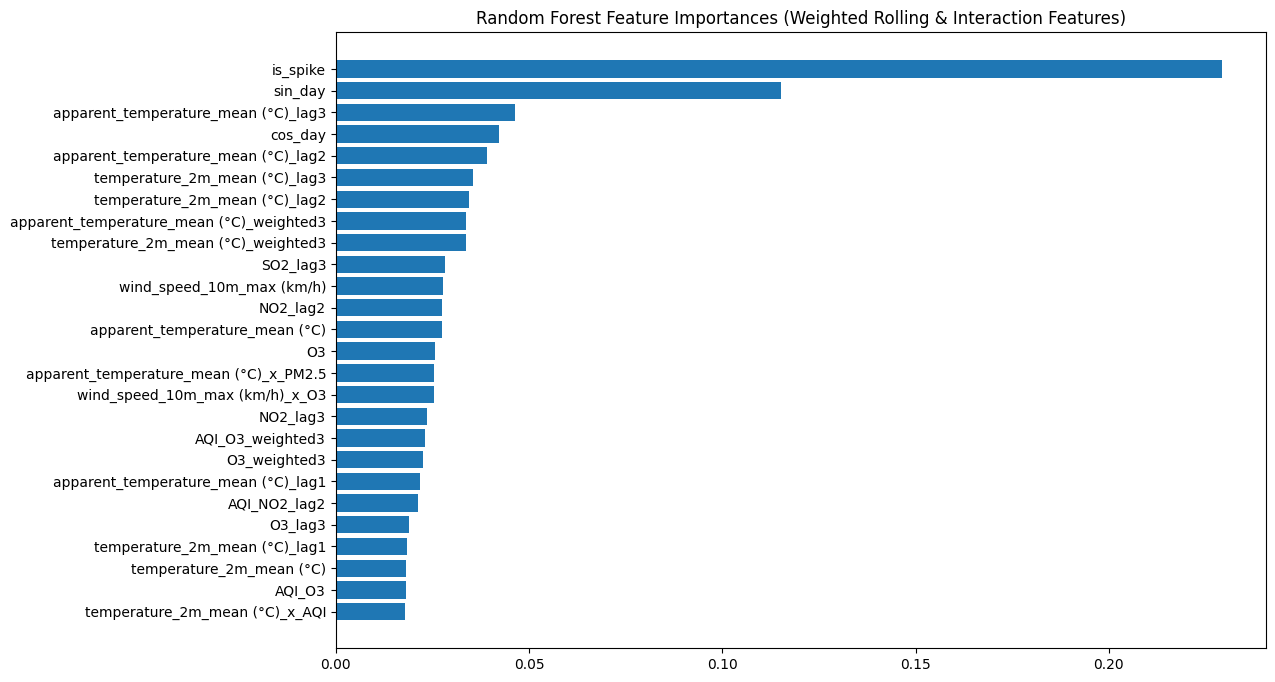

In [207]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Original features ---
features = [
    'temperature_2m_mean (°C)', 'apparent_temperature_mean (°C)', 'precipitation_sum (mm)',
    'wind_gusts_10m_max (km/h)', 'wind_speed_10m_max (km/h)', 'wind_direction_10m_dominant (°)',
    'PM2.5', 'O3', 'CO', 'NO2', 'SO2',
    'AQI_PM2.5', 'AQI_O3', 'AQI_CO', 'AQI_NO2', 'AQI_SO2', 'AQI',
    'day_of_year', 'is_spike'
]

X = df[features].copy()
y = df['Total_Pollen']

# --- Add seasonal features ---
X['sin_day'] = np.sin(2 * np.pi * X['day_of_year'] / 365)
X['cos_day'] = np.cos(2 * np.pi * X['day_of_year'] / 365)
X = X.drop(columns=['day_of_year'])

# --- Weighted rolling averages (3-day) ---
weights = np.array([0.1, 0.3, 0.6])  # older to newer
rolling_cols = [
    'temperature_2m_mean (°C)', 'apparent_temperature_mean (°C)',
    'PM2.5', 'O3', 'CO', 'NO2', 'SO2',
    'AQI_PM2.5', 'AQI_O3', 'AQI_CO', 'AQI_NO2', 'AQI_SO2', 'AQI'
]

for col in rolling_cols:
    X[f'{col}_weighted3'] = (
        X[col].shift(2).bfill() * weights[0] +
        X[col].shift(1).bfill() * weights[1] +
        X[col] * weights[2]
    )

# --- Lag features (t-1, t-2, t-3) ---
for col in rolling_cols:
    for lag in range(1, 4):
        X[f'{col}_lag{lag}'] = X[col].shift(lag).bfill()

# --- Interaction features ---
interaction_pairs = [
    ('temperature_2m_mean (°C)', 'AQI'),
    ('apparent_temperature_mean (°C)', 'PM2.5'),
    ('wind_speed_10m_max (km/h)', 'O3'),
]

for col1, col2 in interaction_pairs:
    X[f'{col1}_x_{col2}'] = X[col1] * X[col2]

# --- Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# --- Sample weights for spikes ---
sample_weights = np.where(X_train['is_spike'] == 1, 1.75, 1)

# --- Initial Random Forest Regressor ---
rf = RandomForestRegressor(
    n_estimators=1200,
    max_depth=None,
    min_samples_split=10,
    min_samples_leaf=4,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

# --- Train ---
rf.fit(X_train, y_train, sample_weight=sample_weights)

# --- Initial Predictions ---
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

# --- Metrics ---
print("Training Metrics:")
print("MAE:", mean_absolute_error(y_train, y_train_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_train, y_train_pred)))
print("R²:", r2_score(y_train, y_train_pred))

print("\nTest Metrics:")
print("MAE:", mean_absolute_error(y_test, y_test_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred)))
print("R²:", r2_score(y_test, y_test_pred))

# --- Feature importance ---
importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf.feature_importances_
}).sort_values(by='importance', ascending=False)

# --- Threshold to trim features ---
importance_threshold = 0.012
important_features = importance[importance['importance'] > importance_threshold]['feature'].tolist()
print(f"\nKeeping {len(important_features)} features out of {len(X_train.columns)}")

# --- Subset for trimmed model ---
X_train_trim = X_train[important_features]
X_test_trim = X_test[important_features]

# --- Re-train RF on trimmed features ---
rf_trim = RandomForestRegressor(
    n_estimators=1200,
    max_depth=None,
    min_samples_split=10,
    min_samples_leaf=4,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

rf_trim.fit(X_train_trim, y_train, sample_weight=sample_weights)

# --- Predictions ---
y_train_pred_trim = rf_trim.predict(X_train_trim)
y_test_pred_trim = rf_trim.predict(X_test_trim)

# --- Metrics for trimmed model ---
print("\nTraining Metrics (Trimmed):")
print("MAE:", mean_absolute_error(y_train, y_train_pred_trim))
print("RMSE:", np.sqrt(mean_squared_error(y_train, y_train_pred_trim)))
print("R²:", r2_score(y_train, y_train_pred_trim))

print("\nTest Metrics (Trimmed):")
print("MAE:", mean_absolute_error(y_test, y_test_pred_trim))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred_trim)))
print("R²:", r2_score(y_test, y_test_pred_trim))

# --- Feature importance for trimmed model ---
importance_trim = pd.DataFrame({
    'feature': X_train_trim.columns,
    'importance': rf_trim.feature_importances_
}).sort_values(by='importance', ascending=False)

print("Feature Importances (Trimmed 22-Feature Model):")
print(importance_trim)

# --- Plot ---

plt.figure(figsize=(12,8))
plt.barh(importance_trim['feature'], importance_trim['importance'])
plt.gca().invert_yaxis()
plt.title('Random Forest Feature Importances (Weighted Rolling & Interaction Features)')
plt.show()
